#  Introduction to Machine Learning — 2024/2025 Evolutionary Algorithms

In [58]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import statistics


### Exercise 1


1. Build the simulation environment. Develop the following functionalities:

a) Create a function that produces a random bit pattern of a specific size (the bit pattern may be coded as a string of 0s and 1s)

In [59]:
def createRandBitPattern(length):
    stringWithIntPattern = ""
    for i in range(length):
        integer = random.randint(0,1)
        stringWithIntPattern += str(integer)

    return(stringWithIntPattern)

b) Create a function that will generate random patterns and measure how many attempts and how much time it takes to generate the “correct” bit pattern. 

Make two graphs on the evolution of attempts / time vs the number of bits in the pattern (2, 4, 8, 12, 16, ...). Each “point” in the graph should be a box-plot based on the results of 30 trials. 

Use a fixed set of seeds to be able to reproduce the experiments. 

In [60]:
def regenerateBitPattern(correctBitPattern):
    startTime = time.time()
    count = 0
    length = len(correctBitPattern)
    generatedBitPattern = createRandBitPattern(length)
    while generatedBitPattern != correctBitPattern:
        generatedBitPattern = createRandBitPattern(length)
        count += 1
    endTime = time.time()
    executionTime = endTime - startTime

    return (count, executionTime)

In [61]:
def getAverageCountsAndTimes(listNumberBits, searchTechnique, giveMeans = False):
    allBitesAllCounts = []
    allBitesAllExecutionTimes = []
    for numberBits in listNumberBits:
        random.seed(13000)
        correctBitPattern = createRandBitPattern(numberBits)
        lengthBitPattern = len(correctBitPattern)
        oneBiteAllCounts = []
        oneBiteAllExecutionTimes = []
        for i in range(30):
            if searchTechnique == "random":
                count, executionTime = regenerateBitPattern(correctBitPattern)
            elif searchTechnique == "mutationRandom":
                randomBitPattern = createRandBitPattern(lengthBitPattern)
                randomBitPattern, count, fitness, executionTime = getCorrectPatternWithMutations(correctBitPattern, randomBitPattern, onlyFitterMutations = False)
            elif searchTechnique == "mutationIfBetter":
                randomBitPattern = createRandBitPattern(lengthBitPattern)
                randomBitPattern, count, fitness, executionTime = getCorrectPatternWithMutations(correctBitPattern, randomBitPattern, onlyFitterMutations = True)
            else:
                print("please choose a valid option: 'random', 'mutationRandom', 'mutationIfBetter' or 'crossover' ")
            oneBiteAllCounts.append(count)
            oneBiteAllExecutionTimes.append(executionTime)
        allBitesAllCounts.append(oneBiteAllCounts)
        allBitesAllExecutionTimes.append(oneBiteAllExecutionTimes)

    # give mean attempt number and execution time 
    if giveMeans == True:
        meansOfAttempts = []
        print("Mean number attempts:")
        for listWithItems in allBitesAllCounts:
            mean = statistics.mean(listWithItems)
            print(round(mean, 0))
            meansOfAttempts.append(mean)

        meansOfExecutionTimes = []
        print("Mean execution time:")
        for listWithItems in allBitesAllExecutionTimes:
            mean = statistics.mean(listWithItems)
            print(round(mean, 4))
            meansOfExecutionTimes.append(mean)

        return (allBitesAllCounts, allBitesAllExecutionTimes, meansOfAttempts, meansOfExecutionTimes)
    
    return (allBitesAllCounts, allBitesAllExecutionTimes)

In [62]:
# give mean attempt number and execution time
listNumberBits = [2, 4, 8, 12, 16]
allBitesAllCountsRandom, allBitesAllExecutionTimesRandom,  meansOfAttemptsRandom, meansOfExecutionTimesRandom = getAverageCountsAndTimes(listNumberBits = listNumberBits, searchTechnique = "random", giveMeans = True) 

Mean number attempts:
2.0
11.0
287.0
3450.0
78901.0
Mean execution time:
0.0
0.0
0.0019
0.0305
0.9868


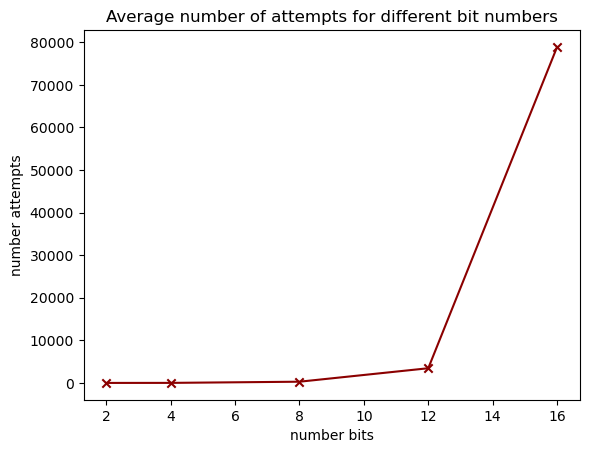

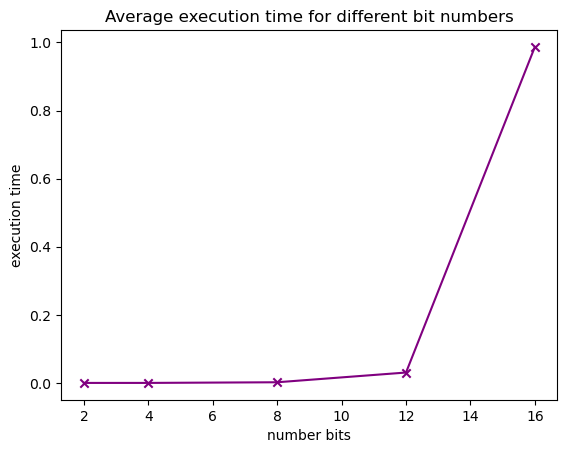

In [63]:
# show in graph
def plotGraph(yCoordinate, title, yLabel, listNumberBits = listNumberBits, colour = "darkred"):
    plt.plot(listNumberBits, yCoordinate, c=colour)
    plt.scatter(listNumberBits, yCoordinate, c=colour, marker='x')
    plt.title(title)
    plt.xlabel("number bits")
    plt.ylabel(yLabel)
    plt.show()

plotGraph(yCoordinate = meansOfAttemptsRandom, title = 'Average number of attempts for different bit numbers', yLabel = "number attempts", colour = "darkred")
plotGraph(yCoordinate = meansOfExecutionTimesRandom, title = 'Average execution time for different bit numbers', yLabel = "execution time", listNumberBits = listNumberBits, colour = "purple")


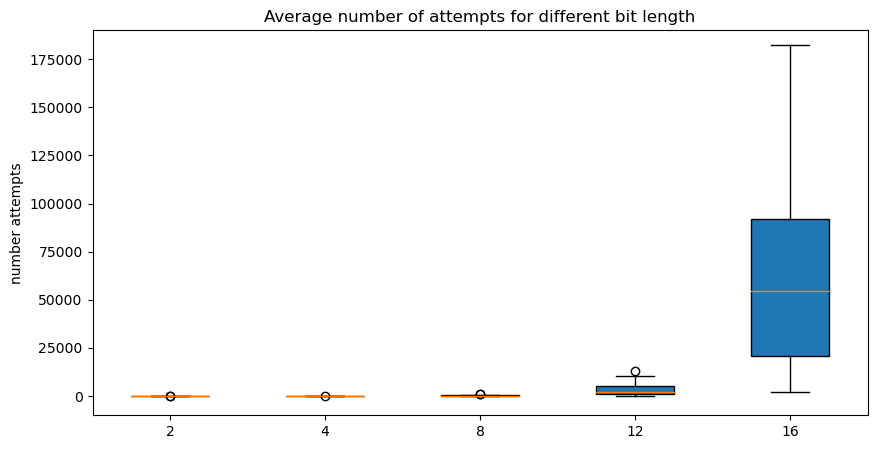

In [64]:
# visualise attempts
def plotBoxplot(boxBlotContent, title, yLabel, labels = listNumberBits, yLim = None):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_ylabel(yLabel)
    ax.set_title(title)
    bplot = ax.boxplot(boxBlotContent, 
                    labels = labels, 
                    patch_artist=True,
                    whis=1.5)
    if yLim != None: 
        ax.set_ylim(yLim)

    plt.show()

plotBoxplot(boxBlotContent = allBitesAllCountsRandom, title = 'Average number of attempts for different bit length', yLabel = "number attempts", labels = listNumberBits, yLim = [-10000, 190000])

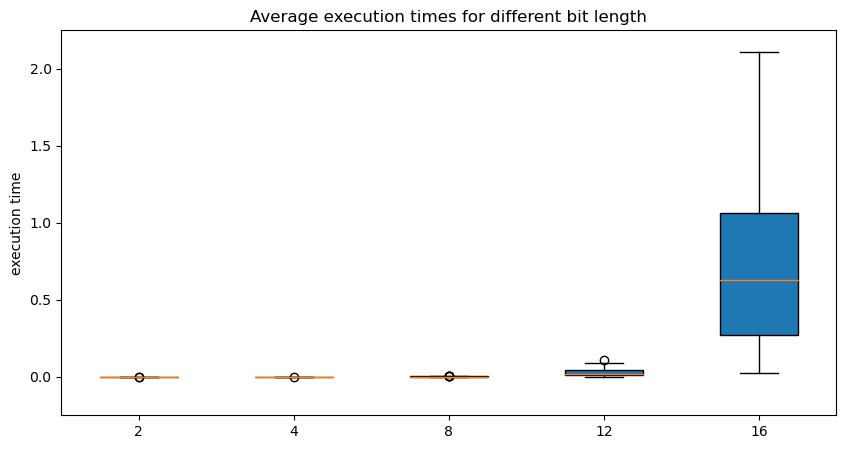

In [65]:
plotBoxplot(boxBlotContent = allBitesAllExecutionTimesRandom, title = 'Average execution times for different bit length', yLabel = "execution time", labels = listNumberBits, yLim = [-0.25, 2.25])

c) Create a function that measures the “fitness” of the guessed pattern.This function should have a maximum value when the guessed pattern matches exactly the “correct” pattern and decreases as the distance between patterns increases.

In [66]:
def measureFitness(correctBitPattern, randomBitPattern):
    totalCorectBits = 0
    totalLengthBitPattern = len(correctBitPattern)
    for position in range(totalLengthBitPattern):
        if correctBitPattern[position] == randomBitPattern[position]:
            totalCorectBits += 1
    # normalise
    normalisedFitness = totalCorectBits/totalLengthBitPattern

    return(normalisedFitness)

# test function
correctBitPattern = createRandBitPattern(16)
randomBitPattern = createRandBitPattern(len(correctBitPattern))
measureFitness(correctBitPattern, randomBitPattern)

0.5

d) Create a function to mutate (flip one bit) a given pattern. Use this function in a loop where the change is accepted only if it generates a better solution (i.e., a solution with higher fitness). Stop after 1000 mutations or when the pattern generated by mutation is equal to the solution. Does it always converge to the correct solution?

In [67]:
def mutateBit(randomBitPattern):
    totalLengthBitPattern = len(randomBitPattern)-1 # -1, because randint includes last integer also
    positionToMutate = random.randint(0, totalLengthBitPattern)
    randomBitPatternMutate = list(randomBitPattern)
    # mutate 
    if randomBitPatternMutate[positionToMutate] == "0":
        randomBitPatternMutate[positionToMutate] = "1"
    elif randomBitPatternMutate[positionToMutate] == "1":
        randomBitPatternMutate[positionToMutate] = "0"
    else:
        print("how possible, neither 0, nor 1")
    
    randomBitPatternMutate = "".join(randomBitPatternMutate) # convert list back to string
    return(randomBitPatternMutate)

def mutateIfBetterFitness(correctBitPattern, randomBitPattern):
    randomBitPatternMutate = mutateBit(randomBitPattern)
    # check if solution is better
    fitnessWithoutMutation = measureFitness(correctBitPattern, randomBitPattern)
    fitnessWithMutation = measureFitness(correctBitPattern, randomBitPatternMutate)
    if fitnessWithMutation >= fitnessWithoutMutation:
        randomBitPattern = randomBitPatternMutate
    
    return(randomBitPattern)

In [68]:
def getCorrectPatternWithMutations(correctBitPattern, randomBitPattern, onlyFitterMutations = True, maxNumberMutations = 1000, withDifferentLengthBits = False):
    startTime = time.time()
    fitness = []
    count = 0
    while correctBitPattern != randomBitPattern and count < maxNumberMutations:
        fitness.append(measureFitness(correctBitPattern, randomBitPattern))
        if onlyFitterMutations == True:
            randomBitPattern = mutateIfBetterFitness(correctBitPattern, randomBitPattern)
        else: 
            randomBitPattern = mutateBit(randomBitPattern)
        count += 1
    endTime = time.time()
    executionTime = endTime - startTime
    if withDifferentLengthBits == True:
        fitness.append(measureFitnessRandomLengthBit(correctBitPattern, randomBitPattern))
    else:
        fitness.append(measureFitness(correctBitPattern, randomBitPattern))

    return(randomBitPattern, count, fitness, executionTime)

# test function
random.seed(130)
lengthBitPattern = 16
correctBitPattern = createRandBitPattern(lengthBitPattern)
randomBitPattern = createRandBitPattern(lengthBitPattern)
randomBitPatternAllMutations, countAllMutations, fitnessAllMutations, executionTimeAllMutations = getCorrectPatternWithMutations(correctBitPattern, randomBitPattern, onlyFitterMutations = False)
randomBitPatternOnlyFitterMutations, countOnlyFitterMutations, fitnessOnlyFitterMutations, executionTimeOnlyFitterMutations = getCorrectPatternWithMutations(correctBitPattern, randomBitPattern, onlyFitterMutations = True)

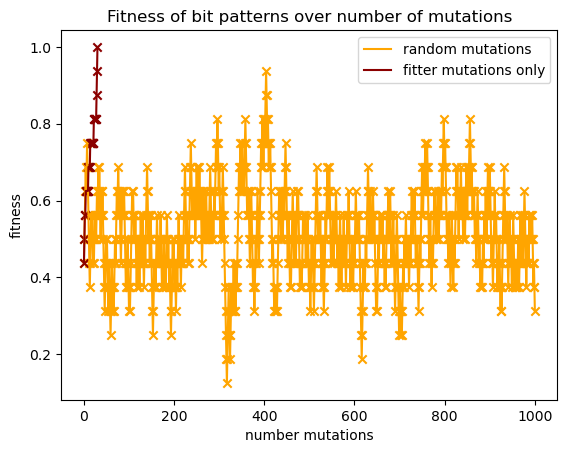

In [69]:
# visualise in graph
plt.plot(range(0, countAllMutations+1), fitnessAllMutations, c="orange", label = "random mutations")
plt.scatter(range(0, countAllMutations+1), fitnessAllMutations, c='orange', marker='x')
plt.plot(range(0, countOnlyFitterMutations+1), fitnessOnlyFitterMutations, c="darkred", label = "fitter mutations only")
plt.scatter(range(0, countOnlyFitterMutations+1), fitnessOnlyFitterMutations, c='darkred', marker='x')
plt.title('Fitness of bit patterns over number of mutations')
plt.xlabel("number mutations")
plt.ylabel("fitness")
plt.legend()
plt.show()


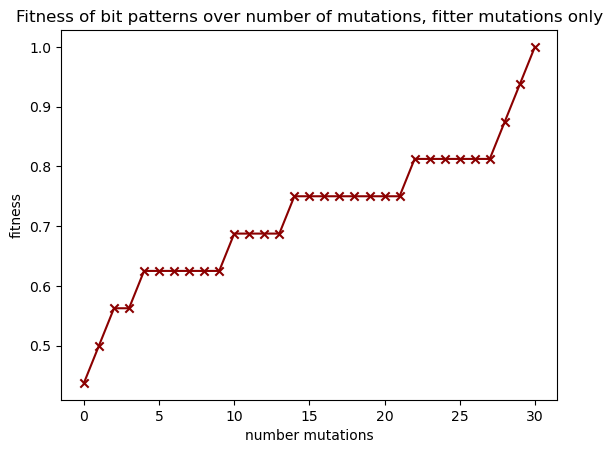

In [71]:
# visualise in graph
plt.plot(range(0, countOnlyFitterMutations+1), fitnessOnlyFitterMutations, c="darkred")
plt.scatter(range(0, countOnlyFitterMutations+1), fitnessOnlyFitterMutations, c='darkred', marker='x')
plt.title('Fitness of bit patterns over number of mutations, fitter mutations only')
plt.xlabel("number mutations")
plt.ylabel("fitness")
plt.show()

In [72]:
# get runtime and attempts over 30 rounds for different bits
allBitesAllCountsMutationRandom, allBitesAllExecutionTimesMutationRandom, meansOfAttemptsMutationRandom, meansOfExecutionTimesMutationRandom = getAverageCountsAndTimes(listNumberBits = listNumberBits, searchTechnique = "mutationRandom", giveMeans=True) 

Mean number attempts:
4.0
18.0
242.0
940.0
1000
Mean execution time:
0.0
0.0001
0.0015
0.0027
0.0031


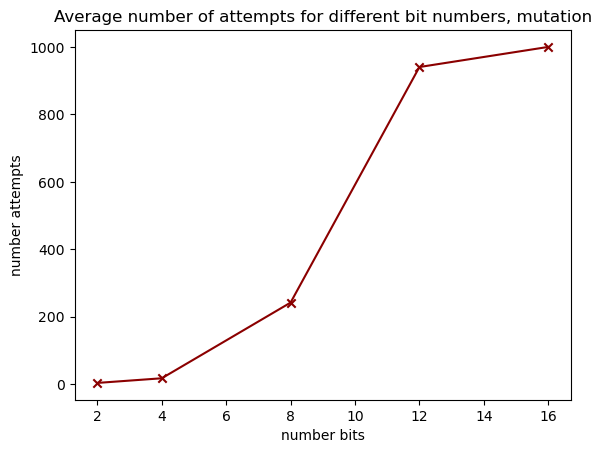

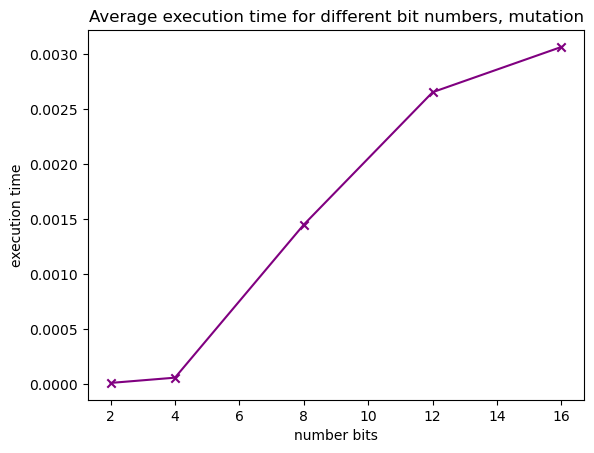

In [73]:
plotGraph(yCoordinate = meansOfAttemptsMutationRandom, title = 'Average number of attempts for different bit numbers, mutation', yLabel = "number attempts", colour = "darkred")
plotGraph(yCoordinate = meansOfExecutionTimesMutationRandom, title = 'Average execution time for different bit numbers, mutation', yLabel = "execution time", listNumberBits = listNumberBits, colour = "purple")

In [74]:
# get runtime and attempts over 30 rounds for different bits
allBitesAllCountsMutationIfBetter, allBitesAllExecutionTimesMutationIfBetter, meansOfAttemptsMutationIfBetter, meansOfExecutionTimesMutationIfBetter = getAverageCountsAndTimes(listNumberBits = listNumberBits, searchTechnique = "mutationIfBetter", giveMeans=True) 

Mean number attempts:
1.0
6.0
17.0
28.0
40.0
Mean execution time:
0.0
0.0
0.0001
0.0002
0.0004


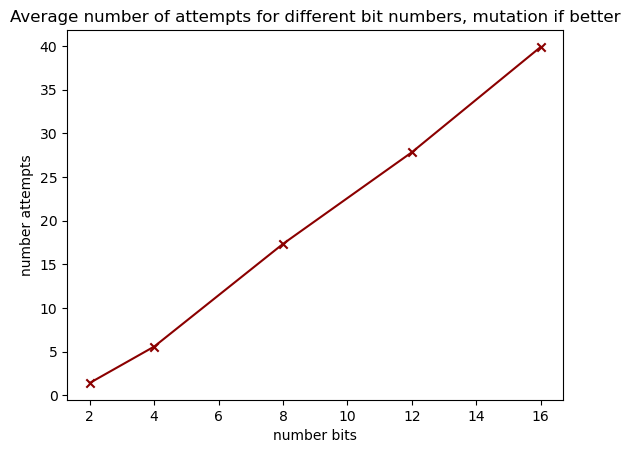

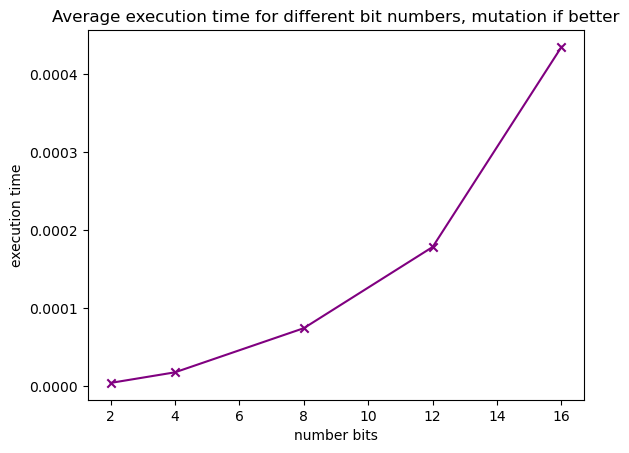

In [75]:
plotGraph(yCoordinate = meansOfAttemptsMutationIfBetter, title = 'Average number of attempts for different bit numbers, mutation if better', yLabel = "number attempts", colour = "darkred")
plotGraph(yCoordinate = meansOfExecutionTimesMutationIfBetter, title = 'Average execution time for different bit numbers, mutation if better', yLabel = "execution time", listNumberBits = listNumberBits, colour = "purple")

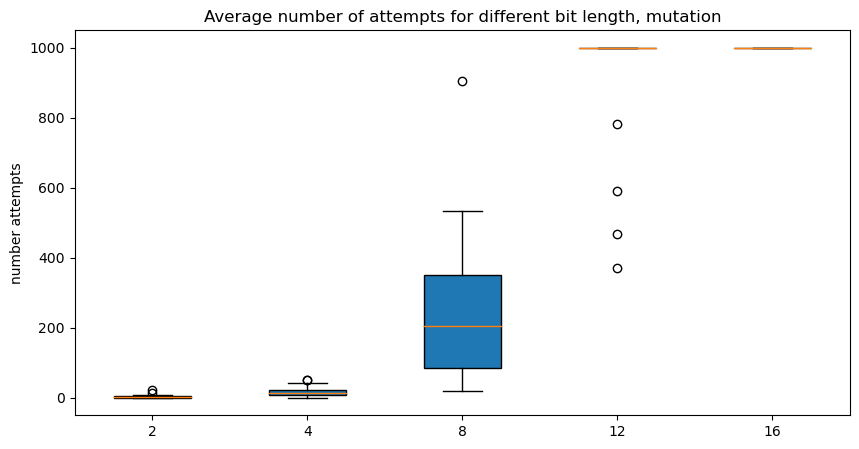

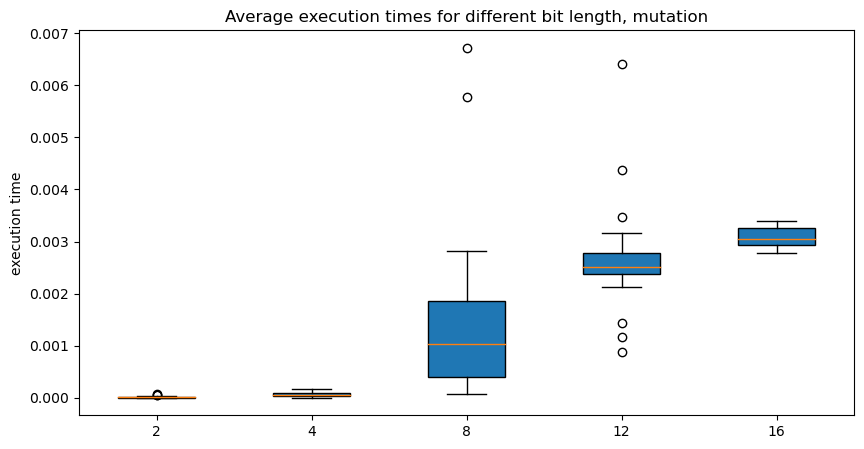

In [76]:
plotBoxplot(boxBlotContent = allBitesAllCountsMutationRandom, title = 'Average number of attempts for different bit length, mutation', yLabel = "number attempts", labels = listNumberBits)
plotBoxplot(boxBlotContent = allBitesAllExecutionTimesMutationRandom, title = 'Average execution times for different bit length, mutation', yLabel = "execution time", labels = listNumberBits)

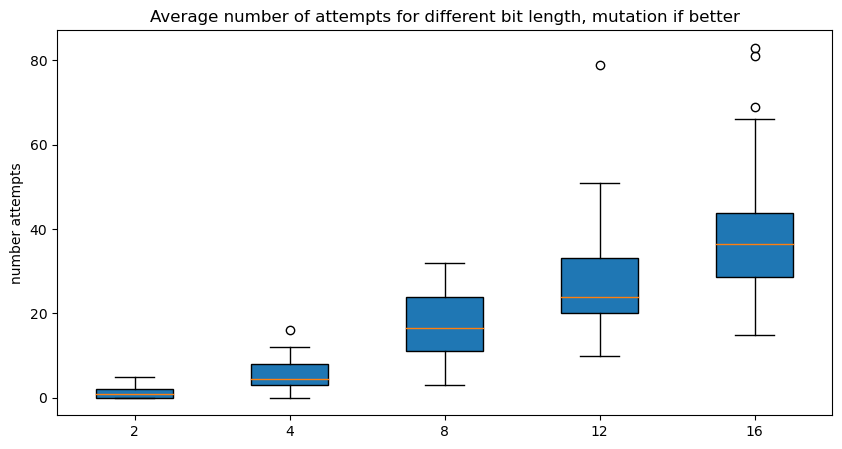

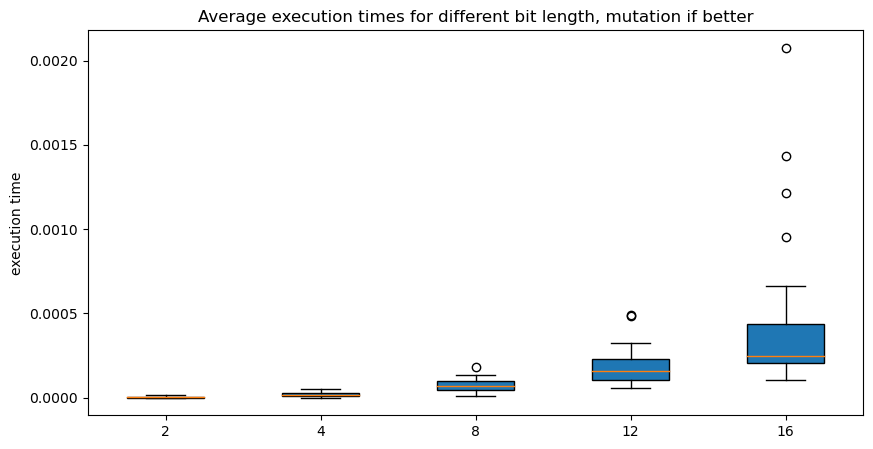

In [77]:
plotBoxplot(boxBlotContent = allBitesAllCountsMutationIfBetter, title = 'Average number of attempts for different bit length, mutation if better', yLabel = "number attempts", labels = listNumberBits)
plotBoxplot(boxBlotContent = allBitesAllExecutionTimesMutationIfBetter, title = 'Average execution times for different bit length, mutation if better', yLabel = "execution time", labels = listNumberBits)

### Does it always converge to the correct solution?
If we only mutate in case the result is better, it always converges within around 40 rounds (for 16 bits). If we also mutate randomly it often does not converge within the window of 1000 rounds (for 16 bits) anymore.


2. Generate a random set of patterns (a population, for example, 100 patterns) and evaluate each of the patterns. 
Select the best 30% and, based on them generate by mutation a new set of 100: 30% of the population corresponds to the 30% best and the remaining 70% are the ones generated by mutation. Repeat the processes until the best evaluation stagnates. Compare fairly the search methods tested so far, including their run-times. Always use 30 tests for each result. Boxplots with whiskers are a good option to compare the results distribution for the several tests.

In [162]:
lengthBitPattern = 16
correctBitPattern = createRandBitPattern(lengthBitPattern)
print(f"Goal bit pattern: {correctBitPattern}")

population = []
for i in range(100):
    individualBitPattern = createRandBitPattern(lengthBitPattern)
    population.append(individualBitPattern)

Goal bit pattern: 1100010101101000


In [22]:
def getBestFitnessIndividuals(listWithSeveralIndividuals, correctBitPattern, percentageBest = 0.3, withDifferentLengthBits = False):
    allFitnesses = []
    for individual in listWithSeveralIndividuals:
        if withDifferentLengthBits == True:
            fitness = measureFitnessRandomLengthBit(correctBitPattern, individual)
        else:
            fitness = measureFitness(correctBitPattern, individual)
        allFitnesses.append(fitness)

    dictPositionToIndividual = {}
    dictPositionToFitness = {}
    for i in range(len(population)):
        dictPositionToIndividual[i] = listWithSeveralIndividuals[i]
        dictPositionToFitness[i] = allFitnesses[i]

    sortedDictByFitness = sorted(dictPositionToFitness, key = dictPositionToFitness.get, reverse = True)
    bestPercent = int(len(sortedDictByFitness)*percentageBest)
    bestFitnessPositions = sortedDictByFitness[:bestPercent]

    # get best individuals
    bestPcIndividuals = []
    for position in range(len(bestFitnessPositions)):
        bestPcIndividuals.append(dictPositionToIndividual[bestFitnessPositions[position]])

    return (bestPcIndividuals)

def mutatePopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3):
    numberOfNewIndividualsNeeded = int((len(listWithBestIndividuals) / percentageBest) - len(listWithBestIndividuals))

    fullNewPopulation = []
    for i in range(len(listWithBestIndividuals)):
        fullNewPopulation.append(listWithBestIndividuals[i])

    for i in range(numberOfNewIndividualsNeeded):
        positionIndividualToMutate = random.randint(0, len(listWithBestIndividuals)-1)
        newIndividual = mutateBit(listWithBestIndividuals[positionIndividualToMutate])
        fullNewPopulation.append(newIndividual)

    return (fullNewPopulation)

def mutateIfBetterPopulationFromBestIndividuals(correctBitPattern, listWithBestIndividuals, percentageBest = 0.3):
    numberOfNewIndividualsNeeded = int((len(listWithBestIndividuals) / percentageBest) - len(listWithBestIndividuals))

    fullNewPopulation = []
    for i in range(len(listWithBestIndividuals)):
        fullNewPopulation.append(listWithBestIndividuals[i])

    for i in range(numberOfNewIndividualsNeeded):
        positionIndividualToMutate = random.randint(0, len(listWithBestIndividuals)-1)
        newIndividual = mutateIfBetterFitness(correctBitPattern, listWithBestIndividuals[positionIndividualToMutate])
        fullNewPopulation.append(newIndividual)

    return (fullNewPopulation)

def measureFitnessOfPopulation(listWithSeveralIndividuals, correctBitPattern, withDifferentLengthBits = False):
    allFitnesses = []
    for individual in listWithSeveralIndividuals:
        if withDifferentLengthBits == True:
            allFitnesses.append(measureFitnessRandomLengthBit(correctBitPattern, individual))
        else: 
            allFitnesses.append(measureFitness(correctBitPattern, individual))

    averageFitnessPopulation = sum(allFitnesses)/len(allFitnesses)

    return (averageFitnessPopulation)

In [ ]:
#def runEvolution(correctBitPattern, listWithSeveralIndividuals,  onlyFitterMutations = False, maxNoImprovement = 5):

    maxNoImprovement = maxNoImprovement
    noImprovementCounter = 0 
    fitnessPopulation = []
    count = 0

    fitnessOldPopulation = measureFitnessOfPopulation(listWithSeveralIndividuals, correctBitPattern)
    listWithBestIndividuals = getBestFitnessIndividuals(listWithSeveralIndividuals, correctBitPattern)

    if onlyFitterMutations == True:
        fullNewPopulation = mutateIfBetterPopulationFromBestIndividuals(correctBitPattern, listWithBestIndividuals)
    else:
        fullNewPopulation = mutatePopulationFromBestIndividuals(listWithBestIndividuals)

    fitnessNewPopulation = measureFitnessOfPopulation(fullNewPopulation, correctBitPattern)

    while noImprovementCounter < maxNoImprovement:
        fitnessOldPopulation = fitnessNewPopulation
        listWithBestIndividuals = getBestFitnessIndividuals(fullNewPopulation, correctBitPattern)
        if onlyFitterMutations == True:
            fullNewPopulation = mutateIfBetterPopulationFromBestIndividuals(correctBitPattern, listWithBestIndividuals)
        else:
            fullNewPopulation = mutatePopulationFromBestIndividuals(listWithBestIndividuals)
        fitnessNewPopulation = measureFitnessOfPopulation(fullNewPopulation, correctBitPattern)

        if fitnessNewPopulation <= fitnessOldPopulation:
            noImprovementCounter += 1 

        fitnessPopulation.append(fitnessOldPopulation)
        count += 1
    fitnessPopulation.append(fitnessNewPopulation)

    return (count, fitnessPopulation)

#testRun = runEvolution(correctBitPattern = correctBitPattern, listWithSeveralIndividuals = population, onlyFitterMutations = False, maxNoImprovement = 1)

In [79]:
def runEvolutionFitnessBest(correctBitPattern, listWithSeveralIndividuals,  onlyFitterMutations = False, maxNoImprovement = 1, withDifferentLengthBits = False):

    maxNoImprovement = maxNoImprovement
    noImprovementCounter = 0 
    fitnessBestPcPopulation = []
    count = 0

    listWithBestIndividuals = getBestFitnessIndividuals(listWithSeveralIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    fitnessBestPcOldPop = measureFitnessOfPopulation(listWithBestIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)

    if onlyFitterMutations == True:
        fullNewPopulation = mutateIfBetterPopulationFromBestIndividuals(correctBitPattern, listWithBestIndividuals)
    else:
        fullNewPopulation = mutatePopulationFromBestIndividuals(listWithBestIndividuals)

    listWithBestIndividuals = getBestFitnessIndividuals(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    fitnessBestPcNewPop = measureFitnessOfPopulation(listWithBestIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)

    while noImprovementCounter < maxNoImprovement:
        #print(fitnessBestPcOldPop)
        fitnessBestPcOldPop = fitnessBestPcNewPop
        #print(fitnessBestPcOldPop)
        if onlyFitterMutations == True:
            fullNewPopulation = mutateIfBetterPopulationFromBestIndividuals(correctBitPattern, listWithBestIndividuals)
        else:
            fullNewPopulation = mutatePopulationFromBestIndividuals(listWithBestIndividuals)
        
        listWithBestIndividuals = getBestFitnessIndividuals(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
        fitnessBestPcNewPop = measureFitnessOfPopulation(listWithBestIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)

        if fitnessBestPcNewPop <= fitnessBestPcOldPop:
            noImprovementCounter += 1 
            #print("no improvement here!")

        fitnessBestPcPopulation.append(fitnessBestPcOldPop)
        count += 1
    fitnessBestPcPopulation.append(fitnessBestPcNewPop)
    #print(fitnessBestPcNewPop)

    return (count, fitnessBestPcPopulation)

In [80]:
countPopBestRandomMutation, fitnessBestPcPopRandomMutation = runEvolutionFitnessBest(correctBitPattern = correctBitPattern, listWithSeveralIndividuals = population, onlyFitterMutations = False, maxNoImprovement = 1)
countPopBestFitterMutation, fitnessBestPcPopFitterMutation = runEvolutionFitnessBest(correctBitPattern = correctBitPattern, listWithSeveralIndividuals = population, onlyFitterMutations = True, maxNoImprovement = 1)

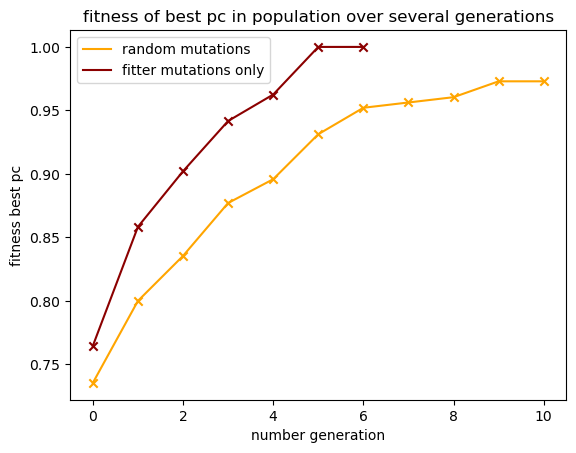

In [81]:
plt.plot(range(countPopBestRandomMutation+1), fitnessBestPcPopRandomMutation, c="orange", label = "random mutations")
plt.scatter(range(countPopBestRandomMutation+1), fitnessBestPcPopRandomMutation, c="orange", marker='x')
plt.plot(range(countPopBestFitterMutation+1), fitnessBestPcPopFitterMutation, c="darkred", label = "fitter mutations only")
plt.scatter(range(countPopBestFitterMutation+1), fitnessBestPcPopFitterMutation, c="darkred", marker='x')
plt.title("fitness of best pc in population over several generations")
plt.xlabel("number generation")
plt.ylabel("fitness best pc")
plt.legend()
plt.show()

In [83]:
# generate population randomly
def randomGenerationPopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3, withDifferentLengthBits = False):
    numberOfNewIndividualsNeeded = int((len(listWithBestIndividuals) / percentageBest) - len(listWithBestIndividuals))
    lengthBitPattern = len(listWithBestIndividuals[0])

    fullNewPopulation = []
    for i in range(len(listWithBestIndividuals)):
        fullNewPopulation.append(listWithBestIndividuals[i])

    for i in range(numberOfNewIndividualsNeeded):
        if withDifferentLengthBits == True:
            individualBitPattern = createBitPatternRandomLength()
        else:
            individualBitPattern = createRandBitPattern(lengthBitPattern)
        fullNewPopulation.append(individualBitPattern)

    return (fullNewPopulation)

#def runEvolutionRandom(correctBitPattern, listWithSeveralIndividuals, maxNoImprovement = 5, withDifferentLengthBits = False):

    maxNoImprovement = maxNoImprovement
    noImprovementCounter = 0 
    fitnessPopulation = []

    fitnessOldPopulation = measureFitnessOfPopulation(listWithSeveralIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    listWithBestIndividuals = getBestFitnessIndividuals(listWithSeveralIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    fullNewPopulation = randomGenerationPopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3, withDifferentLengthBits = withDifferentLengthBits)
    fitnessNewPopulation = measureFitnessOfPopulation(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)

    count = 0
    while noImprovementCounter < maxNoImprovement:
        fitnessOldPopulation = fitnessNewPopulation
        listWithBestIndividuals = getBestFitnessIndividuals(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
        fullNewPopulation = randomGenerationPopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3, withDifferentLengthBits = withDifferentLengthBits)
        fitnessNewPopulation = measureFitnessOfPopulation(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)

        if fitnessNewPopulation <= fitnessOldPopulation:
            noImprovementCounter += 1 
        
        fitnessPopulation.append(fitnessOldPopulation)
        count += 1
    fitnessPopulation.append(fitnessNewPopulation)
    return (count, fitnessPopulation)

#runEvolutionRandom(correctBitPattern, population)

In [84]:
def runEvolutionRandomBest(correctBitPattern, listWithSeveralIndividuals, maxNoImprovement = 1, withDifferentLengthBits = False):

    maxNoImprovement = maxNoImprovement
    noImprovementCounter = 0 
    fitnessBestPopulation = []

    listWithBestIndividuals = getBestFitnessIndividuals(listWithSeveralIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    fitnessOldPopulationBest = measureFitnessOfPopulation(listWithBestIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    fullNewPopulation = randomGenerationPopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3, withDifferentLengthBits = withDifferentLengthBits)
    listWithBestIndividuals = getBestFitnessIndividuals(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    fitnessNewPopulationBest = measureFitnessOfPopulation(listWithBestIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)

    count = 0
    while noImprovementCounter < maxNoImprovement:
        fitnessOldPopulationBest = fitnessNewPopulationBest
        fullNewPopulation = randomGenerationPopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3, withDifferentLengthBits = withDifferentLengthBits)
        listWithBestIndividuals = getBestFitnessIndividuals(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
        fitnessNewPopulationBest = measureFitnessOfPopulation(listWithBestIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)

        if fitnessNewPopulationBest <= fitnessOldPopulationBest:
            noImprovementCounter += 1 
        
        fitnessBestPopulation.append(fitnessOldPopulationBest)
        count += 1
    fitnessBestPopulation.append(fitnessNewPopulationBest)
    return (count, fitnessBestPopulation)

#runEvolutionRandomBest(correctBitPattern, population, 70)

In [85]:
#function to compare mutation vs random generation
def comparePerformances(correctBitPattern, listWithSeveralIndividuals, typeOfLearning, maxNoImprovement = 1, withDifferentLengthBits = False):
    
    allExecutionTimes = []
    allGenerationsCount = []
    allFinalFitnessesBestPc = []
    for i in range(30):

        startTime = time.time()

        if typeOfLearning == "random":
            count, fitnessPopulation = runEvolutionRandomBest(correctBitPattern, listWithSeveralIndividuals, maxNoImprovement, withDifferentLengthBits = withDifferentLengthBits)
        elif typeOfLearning == "mutationRandom":
            count, fitnessPopulation = runEvolutionFitnessBest(correctBitPattern, listWithSeveralIndividuals, onlyFitterMutations = False, maxNoImprovement= maxNoImprovement, withDifferentLengthBits = withDifferentLengthBits)
        elif typeOfLearning == "mutationIfBetter":
            count, fitnessPopulation = runEvolutionFitnessBest(correctBitPattern, listWithSeveralIndividuals, onlyFitterMutations = True, maxNoImprovement= maxNoImprovement, withDifferentLengthBits = withDifferentLengthBits)
        elif typeOfLearning == "crossover":
            count, fitnessPopulation = runEvolutionCrossoverBest(correctBitPattern, listWithSeveralIndividuals, maxNoImprovement= maxNoImprovement, withDifferentLengthBits = withDifferentLengthBits)
        
        endTime = time.time()
        executionTime = endTime - startTime

        allExecutionTimes.append(executionTime)
        allGenerationsCount.append(count)
        allFinalFitnessesBestPc.append(fitnessPopulation[-1])

    return (allGenerationsCount, allExecutionTimes, allFinalFitnessesBestPc)

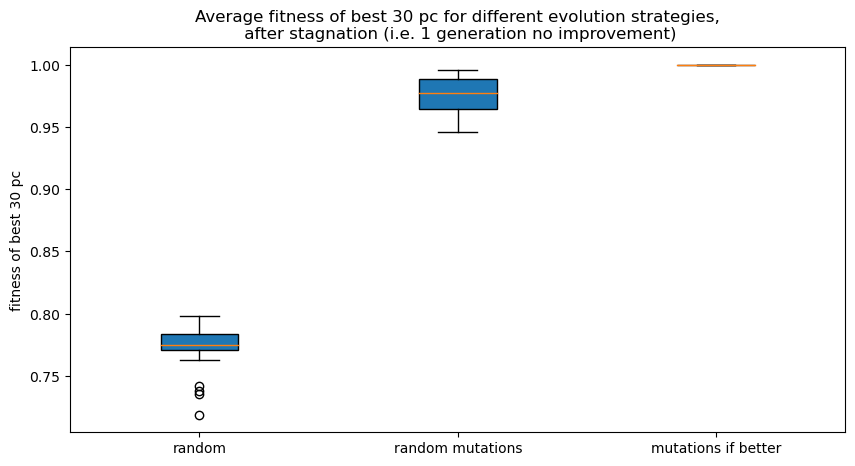

In [ ]:
random.seed(12345678910)
countRandom, timeRandom, popFitnessRandom = comparePerformances(correctBitPattern, population, typeOfLearning="random")
countMutationRandom, timeMutationRandom, popFitnessMutationRandom = comparePerformances(correctBitPattern, population, typeOfLearning="mutationRandom")
countMutationIfBetter, timeMutationIfBetter, popFitnessMutationIfBetter = comparePerformances(correctBitPattern, population, typeOfLearning="mutationIfBetter")

# visualise
listAllFitnessesToCompare = [popFitnessRandom, popFitnessMutationRandom, popFitnessMutationIfBetter]
labelList = ["random", "random mutations", "mutations if better"]
plotBoxplot(boxBlotContent = listAllFitnessesToCompare, title = 'Average fitness of best 30 pc for different evolution strategies,\n after stagnation (i.e. 1 generation no improvement)', yLabel = "fitness of best 30 pc", labels = labelList)
listAllExecutionTimesToCompare = [timeRandom, timeMutationRandom, timeMutationIfBetter]
plotBoxplot(boxBlotContent = listAllExecutionTimesToCompare, title = 'Average execution times for different evolution strategies', yLabel = "execution time", labels = labelList)
listAllGenerationCountsToCompare = [countRandom, countMutationRandom, countMutationIfBetter]
plotBoxplot(boxBlotContent = listAllGenerationCountsToCompare, title = 'Average number of generations until stagnation for different evolution strategies', yLabel = "number of generations", labels = labelList)

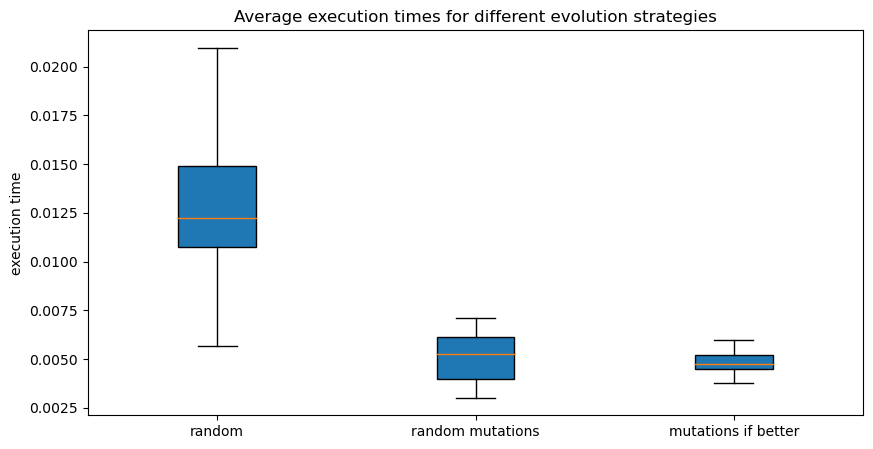

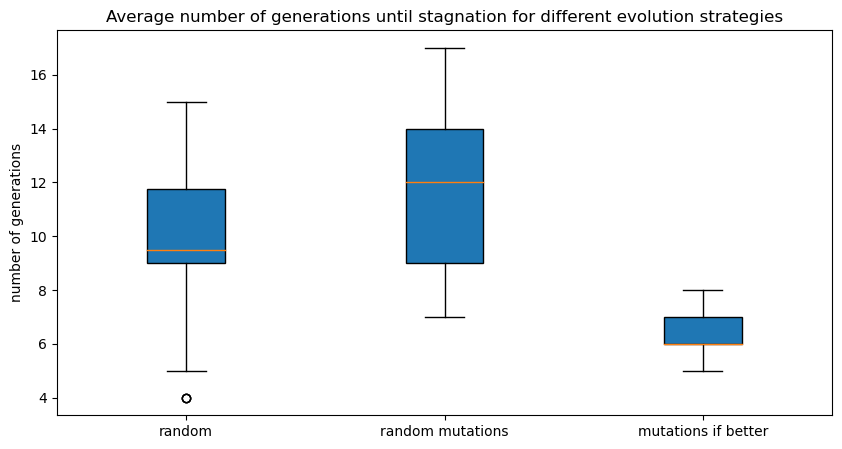

3. Design a crossover procedure for this type of pattern. Test it.

In [131]:
def crossoverBit(bitOne, bitTwo):
    bitOne = list(bitOne)
    bitTwo = list(bitTwo)
    newCrossoverBit = []
    breakPoint = random.randint(1, len(bitTwo)-1)

    for i in range(len(bitTwo)):
        if i < breakPoint:
            newCrossoverBit.append(bitOne[i])
        else:
            newCrossoverBit.append(bitTwo[i])

    newCrossoverBit = "".join(newCrossoverBit)
    return (newCrossoverBit)

def crossoverPopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3):
    numberOfNewIndividualsNeeded = int((len(listWithBestIndividuals) / percentageBest) - len(listWithBestIndividuals))

    fullNewPopulation = []
    for i in range(len(listWithBestIndividuals)):
        fullNewPopulation.append(listWithBestIndividuals[i])

    for i in range(numberOfNewIndividualsNeeded):
        firstPositionIndividualToMutate = random.randint(0, len(listWithBestIndividuals)-1)
        secondPositionIndividualToMutate = random.randint(0, len(listWithBestIndividuals)-1)
        newIndividual = crossoverBit(listWithBestIndividuals[firstPositionIndividualToMutate], listWithBestIndividuals[secondPositionIndividualToMutate])
        fullNewPopulation.append(newIndividual)

    return (fullNewPopulation)

In [160]:
def runEvolutionCrossover(correctBitPattern, listWithSeveralIndividuals, maxNoImprovement = 1, withDifferentLengthBits = False):

    maxNoImprovement = maxNoImprovement
    noImprovementCounter = 0 
    allFitnessesBest = []

    fitnessOldPopulation = measureFitnessOfPopulation(listWithSeveralIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    listWithBestIndividuals = getBestFitnessIndividuals(listWithSeveralIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    fullNewPopulation = crossoverPopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3)
    fitnessNewPopulation = measureFitnessOfPopulation(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    
    count = 0
    while noImprovementCounter < maxNoImprovement:
        fitnessOldPopulation = fitnessNewPopulation
        listWithBestIndividuals = getBestFitnessIndividuals(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
        fullNewPopulation = crossoverPopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3)
        fitnessNewPopulation = measureFitnessOfPopulation(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
        
        allFitnessesBest.append(fitnessOldPopulation)

        if fitnessNewPopulation <= fitnessOldPopulation:
            noImprovementCounter += 1 

        count += 1
    allFitnessesBest.append(fitnessNewPopulation)

    return (count, allFitnessesBest)

def runEvolutionCrossoverBest(correctBitPattern, listWithSeveralIndividuals, maxNoImprovement = 1, withDifferentLengthBits = False):

    maxNoImprovement = maxNoImprovement
    noImprovementCounter = 0 
    allFitnessesBest = []

    listWithBestIndividuals = getBestFitnessIndividuals(listWithSeveralIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    fitnessOldPopulation = measureFitnessOfPopulation(listWithBestIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    fullNewPopulation = crossoverPopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3)
    listWithBestIndividuals = getBestFitnessIndividuals(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
    fitnessNewPopulation = measureFitnessOfPopulation(listWithBestIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)

    count = 0
    while noImprovementCounter < maxNoImprovement:
        fitnessOldPopulation = fitnessNewPopulation
        fullNewPopulation = crossoverPopulationFromBestIndividuals(listWithBestIndividuals, percentageBest = 0.3)
        listWithBestIndividuals = getBestFitnessIndividuals(fullNewPopulation, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)
        fitnessNewPopulation = measureFitnessOfPopulation(listWithBestIndividuals, correctBitPattern, withDifferentLengthBits = withDifferentLengthBits)

        allFitnessesBest.append(fitnessOldPopulation)

        if fitnessNewPopulation <= fitnessOldPopulation:
            noImprovementCounter += 1 

        count += 1
    allFitnessesBest.append(fitnessNewPopulation)

    return (count, allFitnessesBest)

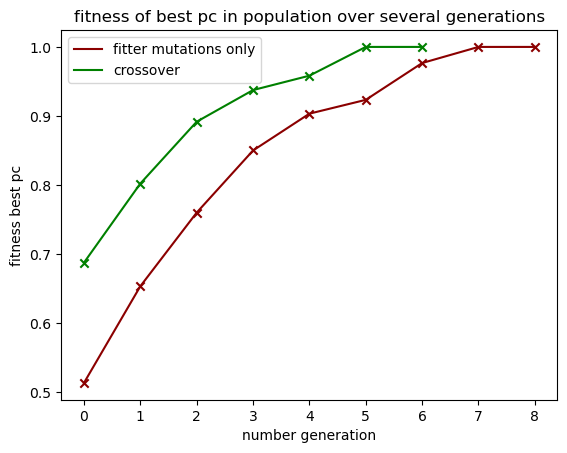

In [163]:
countCrossover, fitnessBestPcCrossover = runEvolutionCrossoverBest(correctBitPattern, population)

#plt.plot(range(countPopBestRandomMutation+1), fitnessBestPcPopRandomMutation, c="orange", label = "random mutations")
#plt.scatter(range(countPopBestRandomMutation+1), fitnessBestPcPopRandomMutation, c="orange", marker='x')
plt.plot(range(countPopBestFitterMutation+1), fitnessBestPcPopFitterMutation, c="darkred", label = "fitter mutations only")
plt.scatter(range(countPopBestFitterMutation+1), fitnessBestPcPopFitterMutation, c="darkred", marker='x')
plt.plot(range(countCrossover+1), fitnessBestPcCrossover, c="green", label = "crossover")
plt.scatter(range(countCrossover+1), fitnessBestPcCrossover, c="green", marker='x')
plt.title("fitness of best pc in population over several generations")
plt.xlabel("number generation")
plt.ylabel("fitness best pc")
plt.legend()
plt.show()

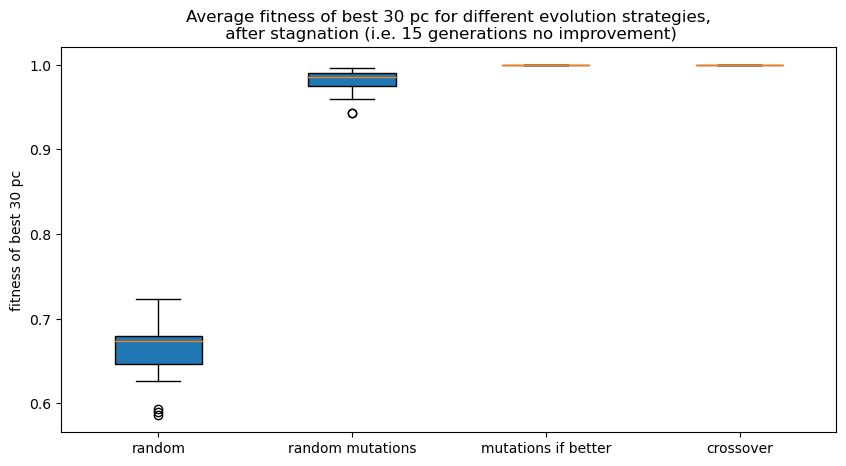

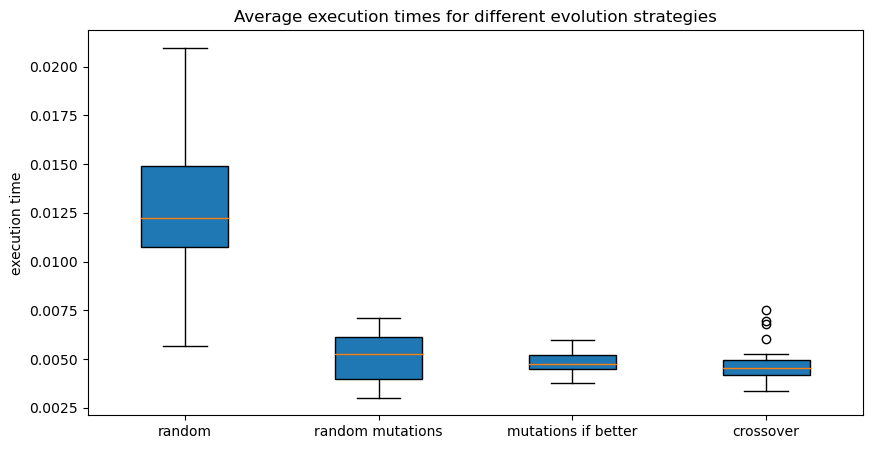

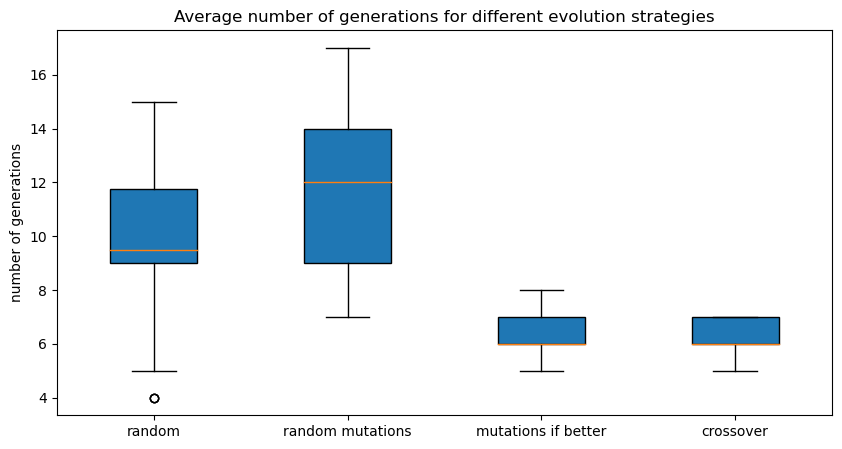

In [164]:
# compare crossover with the rest
random.seed(12345678910)
countCrossOver, timeMutationCrossOver, popFitnessCrossOver = comparePerformances(correctBitPattern, population, typeOfLearning="crossover")

listAllFitnessesToCompare.append(popFitnessCrossOver)
listAllExecutionTimesToCompare.append(timeMutationCrossOver)
listAllGenerationCountsToCompare.append(countCrossOver)
labelList.append("crossover")
plotBoxplot(boxBlotContent = listAllFitnessesToCompare, title = 'Average fitness of best 30 pc for different evolution strategies,\n after stagnation (i.e. 15 generations no improvement)', yLabel = "fitness of best 30 pc", labels = labelList)
plotBoxplot(boxBlotContent = listAllExecutionTimesToCompare, title = 'Average execution times for different evolution strategies', yLabel = "execution time", labels = labelList)
plotBoxplot(boxBlotContent = listAllGenerationCountsToCompare, title = 'Average number of generations for different evolution strategies', yLabel = "number of generations", labels = labelList)


### Exercise 2

Explain the changes that would be necessary in the evaluation function, mutation, and crossover to deal with a similar problem where the **size of the target bit pattern would be unknown**.

In [89]:
# changed bit generation function
def createBitPatternRandomLength():
    length = random.randint(1, 16)
    stringWithIntPattern = createRandBitPattern(length)
    return(stringWithIntPattern)

def regenerateBitPattern(correctBitPattern):
    startTime = time.time()
    count = 0
    generatedBitPattern = createBitPatternRandomLength()
    while generatedBitPattern != correctBitPattern:
        generatedBitPattern = createBitPatternRandomLength()
        count += 1
    endTime = time.time()
    executionTime = endTime - startTime

    return (count, executionTime)

#def getAverageCountsAndTimesAllRandom(searchTechnique, giveMeans = False):
    allBitesAllCounts = []
    allBitesAllExecutionTimes = []

    random.seed(13000)
    correctBitPattern = createBitPatternRandomLength()
    oneBiteAllCounts = []
    oneBiteAllExecutionTimes = []
    for i in range(30):
        if searchTechnique == "random":
            count, executionTime = regenerateBitPattern(correctBitPattern)
        elif searchTechnique == "mutationRandom":
            randomBitPattern = createRandBitPattern(lengthBitPattern)
            randomBitPattern, count, fitness, executionTime = getCorrectPatternWithMutations(correctBitPattern, randomBitPattern, onlyFitterMutations = False)
        elif searchTechnique == "mutationIfBetter":
            randomBitPattern = createRandBitPattern(lengthBitPattern)
            randomBitPattern, count, fitness, executionTime = getCorrectPatternWithMutations(correctBitPattern, randomBitPattern, onlyFitterMutations = True)
        else:
            print("please choose a valid option: 'random', 'mutationRandom', 'mutationIfBetter' or 'crossover' ")
        oneBiteAllCounts.append(count)
        oneBiteAllExecutionTimes.append(executionTime)
    allBitesAllCounts.append(oneBiteAllCounts)
    allBitesAllExecutionTimes.append(oneBiteAllExecutionTimes)

    # give mean attempt number and execution time 
    if giveMeans == True:
        meansOfAttempts = []
        print("Mean number attempts:")
        for listWithItems in allBitesAllCounts:
            mean = statistics.mean(listWithItems)
            print(round(mean, 0))
            meansOfAttempts.append(mean)

        meansOfExecutionTimes = []
        print("Mean execution time:")
        for listWithItems in allBitesAllExecutionTimes:
            mean = statistics.mean(listWithItems)
            print(round(mean, 4))
            meansOfExecutionTimes.append(mean)

        return (allBitesAllCounts, allBitesAllExecutionTimes, meansOfAttempts, meansOfExecutionTimes)
    
    return (allBitesAllCounts, allBitesAllExecutionTimes)

Mean number attempts:
57.0
362.0
4405.0
57963.0
1218609.0
Mean execution time:
0.0004
0.0025
0.0332
0.3997
8.4855


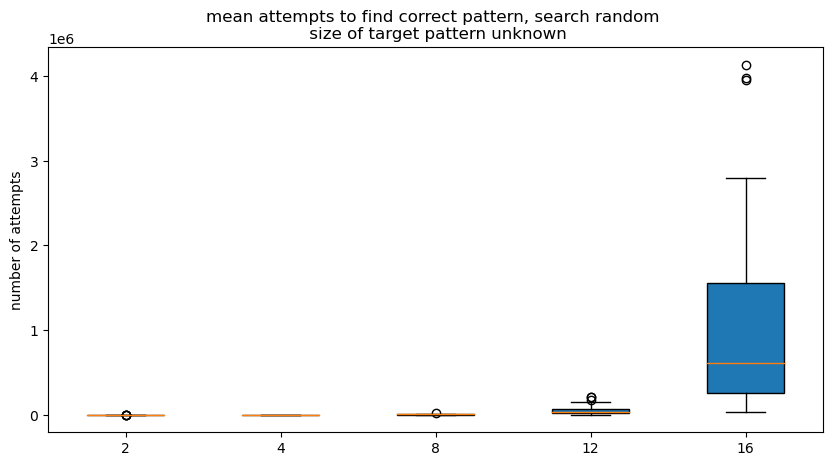

In [ ]:
# changes performance of finding bit pattern dramatically

regenerateBitPattern(correctBitPattern)
numberAttemptsRandom, executionTimeRandom, meansOfAttemptsRandom, meansOfExecutionTimesRandom = getAverageCountsAndTimes(listNumberBits, "random", giveMeans=True)

plotBoxplot(boxBlotContent = numberAttemptsRandom, title = "mean attempts to find correct pattern, search random \n size of target pattern unknown", yLabel = "number of attempts", labels = listNumberBits, yLim = None)
plotBoxplot(boxBlotContent = executionTimeRandom, title = "mean execution time to find correct pattern, search random \n size of target pattern unknown", yLabel = "execution time", labels = listNumberBits, yLim = None)

In [90]:
# changed evaluation function
def measureFitnessRandomLengthBit(correctBitPattern, randomBitPattern):
    totalCorrectBits = 0
    totalLengthBitPattern = min(len(correctBitPattern), len(randomBitPattern))

    for position in range(totalLengthBitPattern):
        if correctBitPattern[position] == randomBitPattern[position]:
            totalCorrectBits += 1
    
    lengthDifference = abs(len(correctBitPattern) - len(randomBitPattern))
    overallPoints = totalCorrectBits - lengthDifference
    overallPoints = max(0, overallPoints)
    # normalise
    normalisedFitness = overallPoints/len(correctBitPattern)

    return(normalisedFitness)

# test function
correctBitPattern = createBitPatternRandomLength()
print(correctBitPattern)
randomBitPattern = createBitPatternRandomLength()
print(randomBitPattern)
measureFitnessRandomLengthBit(correctBitPattern, randomBitPattern)

00000111011
0111110


0.0

In [91]:
# changed mutation function
def mutateBit(randomBitPattern):
    totalLengthBitPattern = len(randomBitPattern)+1
    positionToMutate = random.randint(0, totalLengthBitPattern)
    randomBitPatternMutate = list(randomBitPattern)

    if positionToMutate == totalLengthBitPattern:
        randomBitPatternMutate.append(createRandBitPattern(length = 1))
    elif positionToMutate == totalLengthBitPattern -1:
        if totalLengthBitPattern != 1:
            randomBitPatternMutate = randomBitPatternMutate[:-1]

    else:
        if randomBitPatternMutate[positionToMutate] == "0":
            randomBitPatternMutate[positionToMutate] = "1"
        elif randomBitPatternMutate[positionToMutate] == "1":
            randomBitPatternMutate[positionToMutate] = "0"
        else:
            print("how possible, neither 0, nor 1")
    
    randomBitPatternMutate = "".join(randomBitPatternMutate) # convert list back to string
    return(randomBitPatternMutate)

def mutateIfBetterFitness(correctBitPattern, randomBitPattern):
    randomBitPatternMutate = mutateBit(randomBitPattern)
    # check if solution is better
    fitnessWithoutMutation = measureFitnessRandomLengthBit(correctBitPattern, randomBitPattern)
    fitnessWithMutation = measureFitnessRandomLengthBit(correctBitPattern, randomBitPatternMutate)
    if fitnessWithMutation >= fitnessWithoutMutation:
        randomBitPattern = randomBitPatternMutate
    
    return(randomBitPattern)

In [154]:
# changed crossover function
def crossoverBit(bitOne, bitTwo):
    bitOne = list(bitOne)
    bitTwo = list(bitTwo)
    newCrossoverBit = []
    minLength = min(len(bitOne), len(bitTwo))
    if minLength == 1:
        breakPoint = 1
    else:
        breakPoint = random.randint(1, minLength-1)
    for i in range(minLength):
        if i < breakPoint:
            newCrossoverBit.append(bitOne[i])
        else:
            newCrossoverBit.append(bitTwo[i])
    
    if len(bitOne) != len(bitTwo):
        maxLength = max(len(bitOne), len(bitTwo))
        longerBit = bitOne if len(bitOne) > len(bitTwo) else bitTwo
        howMuchLonger = maxLength - minLength
        randomNumberToAppend = random.randint(0,  howMuchLonger)
        if randomNumberToAppend > 0:
            extraBits = longerBit[-randomNumberToAppend:]
            newCrossoverBit.extend(extraBits)

    newCrossoverBit = "".join(newCrossoverBit)

    return (newCrossoverBit)

In [166]:
# population
random.seed(123456)
correctBitPattern = createBitPatternRandomLength()
print(f"Goal bit pattern: {correctBitPattern}")

population = []
for i in range(100):
    individualBitPattern = createBitPatternRandomLength()
    population.append(individualBitPattern)


Goal bit pattern: 0000010001


In [167]:
countPopBestRandomMutation, fitnessBestPcPopRandomMutation = runEvolutionFitnessBest(correctBitPattern = correctBitPattern, listWithSeveralIndividuals = population, onlyFitterMutations = False, maxNoImprovement = 1, withDifferentLengthBits = True)
countPopBestFitterMutation, fitnessBestPcPopFitterMutation = runEvolutionFitnessBest(correctBitPattern = correctBitPattern, listWithSeveralIndividuals = population, onlyFitterMutations = True, maxNoImprovement = 1, withDifferentLengthBits = True)
countCrossover, fitnessBestPcCrossover = runEvolutionCrossoverBest(correctBitPattern, population, withDifferentLengthBits = True)


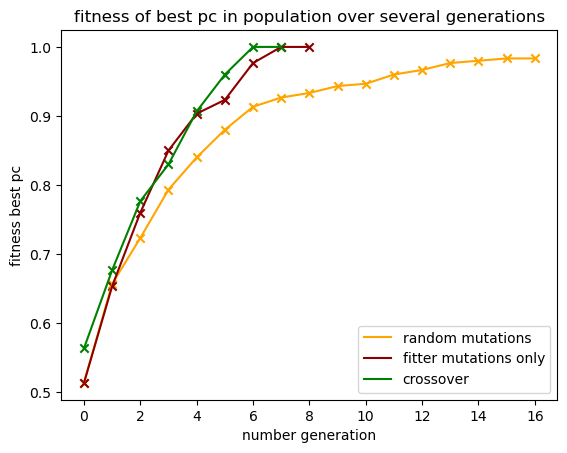

In [168]:
plt.plot(range(countPopBestRandomMutation+1), fitnessBestPcPopRandomMutation, c="orange", label = "random mutations")
plt.scatter(range(countPopBestRandomMutation+1), fitnessBestPcPopRandomMutation, c="orange", marker='x')
plt.plot(range(countPopBestFitterMutation+1), fitnessBestPcPopFitterMutation, c="darkred", label = "fitter mutations only")
plt.scatter(range(countPopBestFitterMutation+1), fitnessBestPcPopFitterMutation, c="darkred", marker='x')
plt.plot(range(countCrossover+1), fitnessBestPcCrossover, c="green", label = "crossover")
plt.scatter(range(countCrossover+1), fitnessBestPcCrossover, c="green", marker='x')
plt.title("fitness of best pc in population over several generations")
plt.xlabel("number generation")
plt.ylabel("fitness best pc")
plt.legend()
plt.show()

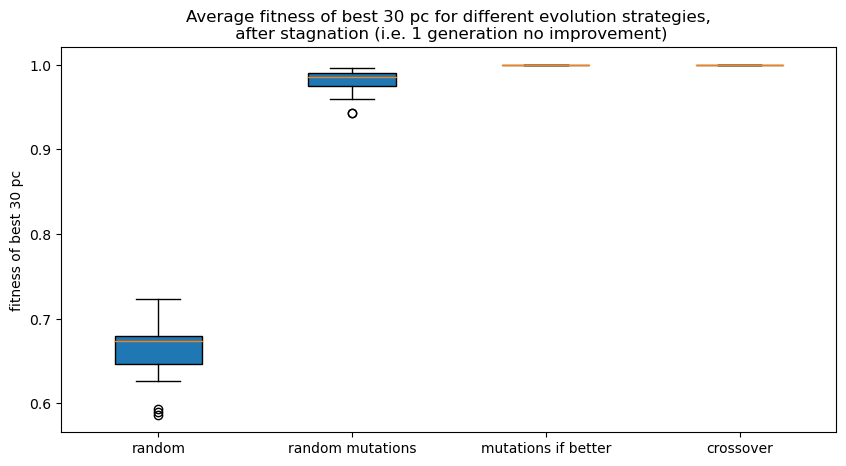

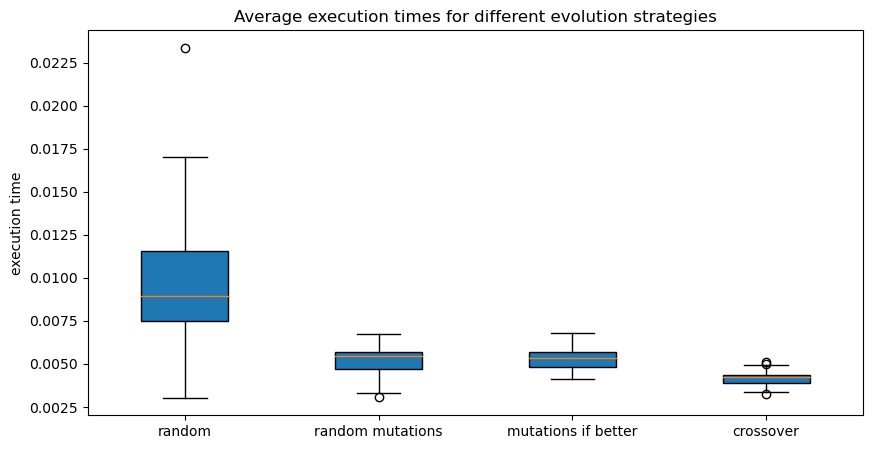

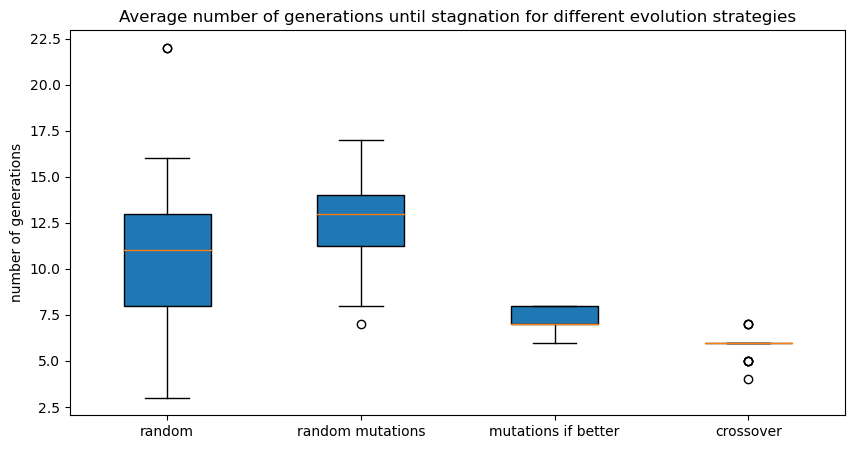

In [169]:
# test performances
random.seed(12345678910)
countRandom, timeRandom, popFitnessRandom = comparePerformances(correctBitPattern, population, typeOfLearning="random", withDifferentLengthBits=True)
countMutationRandom, timeMutationRandom, popFitnessMutationRandom = comparePerformances(correctBitPattern, population, typeOfLearning="mutationRandom", withDifferentLengthBits=True)
countMutationIfBetter, timeMutationIfBetter, popFitnessMutationIfBetter = comparePerformances(correctBitPattern, population, typeOfLearning="mutationIfBetter", withDifferentLengthBits=True)
countCrossOver, timeMutationCrossOver, popFitnessCrossOver = comparePerformances(correctBitPattern, population, typeOfLearning="crossover", withDifferentLengthBits=True)

# visualise
listAllFitnessesToCompare = [popFitnessRandom, popFitnessMutationRandom, popFitnessMutationIfBetter, popFitnessCrossOver]
listAllExecutionTimesToCompare = [timeRandom, timeMutationRandom, timeMutationIfBetter, timeMutationCrossOver]
listAllGenerationCountsToCompare = [countRandom, countMutationRandom, countMutationIfBetter, countCrossOver]
labelList = ["random", "random mutations", "mutations if better", "crossover"]
plotBoxplot(boxBlotContent = listAllFitnessesToCompare, title = 'Average fitness of best 30 pc for different evolution strategies,\n after stagnation (i.e. 1 generation no improvement)', yLabel = "fitness of best 30 pc", labels = labelList)
plotBoxplot(boxBlotContent = listAllExecutionTimesToCompare, title = 'Average execution times for different evolution strategies', yLabel = "execution time", labels = labelList)
plotBoxplot(boxBlotContent = listAllGenerationCountsToCompare, title = 'Average number of generations until stagnation for different evolution strategies', yLabel = "number of generations", labels = labelList)


### Exercise 3

Explain the changes that would be necessary in the evaluation function, mutation, and crossover to deal with a similar problem where the **pattern would be of decimal digits and not binary**.

In [294]:
# changed bit generation function
def createRandBitPattern(length):
    stringWithIntPattern = ""
    for i in range(length):
        integer = random.randint(0,9)
        stringWithIntPattern += str(integer)

    return(stringWithIntPattern)

def regenerateBitPattern(correctBitPattern):
    startTime = time.time()
    count = 0
    length = len(correctBitPattern)
    generatedBitPattern = createRandBitPattern(length)
    while generatedBitPattern != correctBitPattern:
        generatedBitPattern = createRandBitPattern(length)
        count += 1
    endTime = time.time()
    executionTime = endTime - startTime

    return (count, executionTime)


Mean number attempts:
7.0
86.0
1136.0
10498.0
112957.0
Mean execution time:
0.0
0.0002
0.0033
0.0349
0.4367


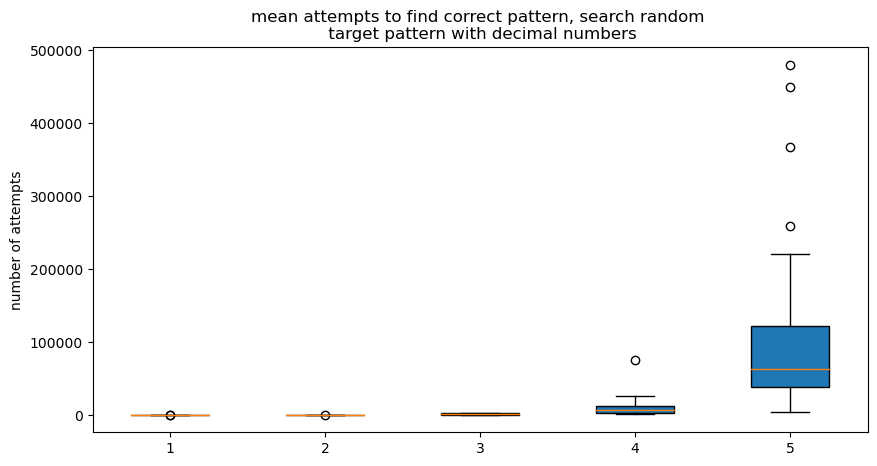

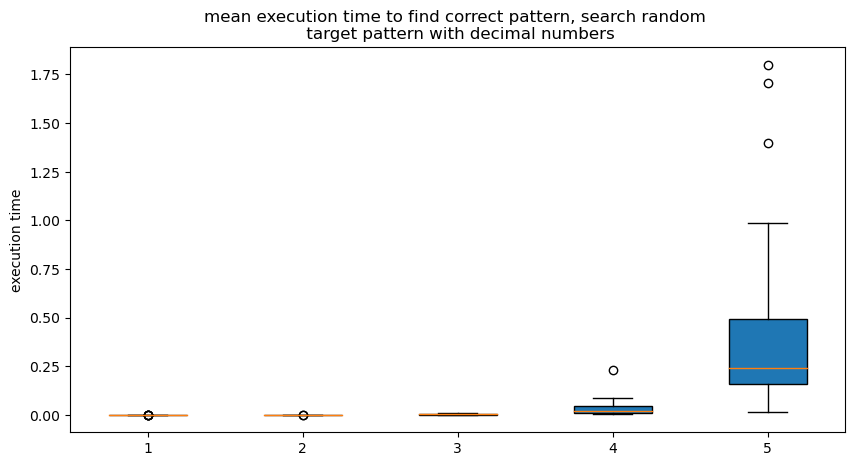

In [ ]:
# changes performance of finding bit pattern even worse!
# since it would not finish otherwise, we use shorter patterns here.
listNumberBits = [1,2,3,4,5]
numberAttemptsRandom, executionTimeRandom, meansOfAttemptsRandom, meansOfExecutionTimesRandom = getAverageCountsAndTimes(listNumberBits, "random", giveMeans=True)

plotBoxplot(boxBlotContent = numberAttemptsRandom, title = "mean attempts to find correct pattern, search random \n target pattern with decimal numbers", yLabel = "number of attempts", labels = listNumberBits, yLim = None)
plotBoxplot(boxBlotContent = executionTimeRandom, title = "mean execution time to find correct pattern, search random \n target pattern with decimal numbers", yLabel = "execution time", labels = listNumberBits, yLim = None)

In [ ]:
# we do not need to implement any changes in the fitness measuring function
# it simply performs a lot worse (since probability to be correct per item = 1/9 and not 1/2 anymore)
correctBitPattern = createRandBitPattern(2)
randomBitPattern = createRandBitPattern(len(correctBitPattern))
measureFitness(correctBitPattern, randomBitPattern)

0.5

In [291]:
def mutateBit(randomBitPattern):
    totalLengthBitPattern = len(randomBitPattern)-1 # -1, because randint includes last integer also
    positionToMutate = random.randint(0, totalLengthBitPattern)
    randomBitPatternMutate = list(randomBitPattern)
    # mutate 
    possibleDecimals =["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    for decimal in possibleDecimals:
        if decimal == randomBitPatternMutate[positionToMutate]:
            possibleDecimals.remove(decimal)
    newDecimalPositionListPossibleDecimals = random.randint(0, len(possibleDecimals)-1)
    randomBitPatternMutate[positionToMutate] = possibleDecimals[newDecimalPositionListPossibleDecimals]
    randomBitPatternMutate = "".join(randomBitPatternMutate) # convert list back to string
    return(randomBitPatternMutate)

def mutateIfBetterFitness(correctBitPattern, randomBitPattern):
    randomBitPatternMutate = mutateBit(randomBitPattern)
    # check if solution is better
    fitnessWithoutMutation = measureFitness(correctBitPattern, randomBitPattern)
    fitnessWithMutation = measureFitness(correctBitPattern, randomBitPatternMutate)
    if fitnessWithMutation >= fitnessWithoutMutation:
        randomBitPattern = randomBitPatternMutate
    
    return(randomBitPattern)

In [293]:
# crossover function does not need to be changed

In [295]:
# population
random.seed(123456)
length = 4
correctBitPattern = createRandBitPattern(length)
print(f"Goal bit pattern: {correctBitPattern}")

population = []
for i in range(100):
    individualBitPattern = createRandBitPattern(length)
    population.append(individualBitPattern)


Goal bit pattern: 4020


In [296]:
countPopBestRandomMutation, fitnessBestPcPopRandomMutation = runEvolutionFitnessBest(correctBitPattern = correctBitPattern, listWithSeveralIndividuals = population, onlyFitterMutations = False, maxNoImprovement = 1)
countPopBestFitterMutation, fitnessBestPcPopFitterMutation = runEvolutionFitnessBest(correctBitPattern = correctBitPattern, listWithSeveralIndividuals = population, onlyFitterMutations = True, maxNoImprovement = 1)
countCrossover, fitnessBestPcCrossover = runEvolutionCrossoverBest(correctBitPattern, population)


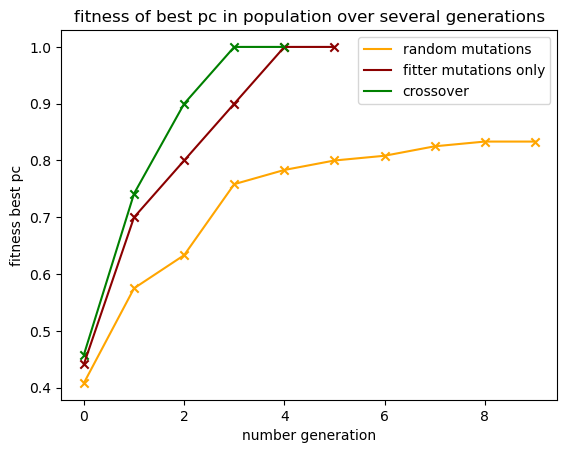

In [297]:
plt.plot(range(countPopBestRandomMutation+1), fitnessBestPcPopRandomMutation, c="orange", label = "random mutations")
plt.scatter(range(countPopBestRandomMutation+1), fitnessBestPcPopRandomMutation, c="orange", marker='x')
plt.plot(range(countPopBestFitterMutation+1), fitnessBestPcPopFitterMutation, c="darkred", label = "fitter mutations only")
plt.scatter(range(countPopBestFitterMutation+1), fitnessBestPcPopFitterMutation, c="darkred", marker='x')
plt.plot(range(countCrossover+1), fitnessBestPcCrossover, c="green", label = "crossover")
plt.scatter(range(countCrossover+1), fitnessBestPcCrossover, c="green", marker='x')
plt.title("fitness of best pc in population over several generations")
plt.xlabel("number generation")
plt.ylabel("fitness best pc")
plt.legend()
plt.show()

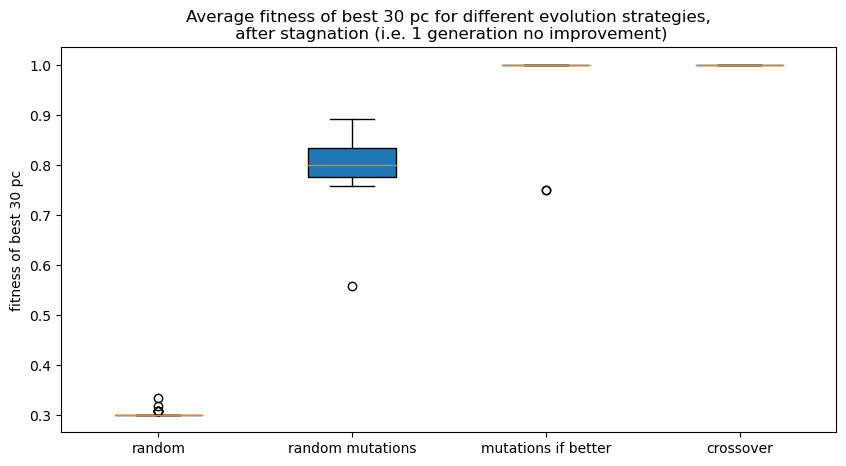

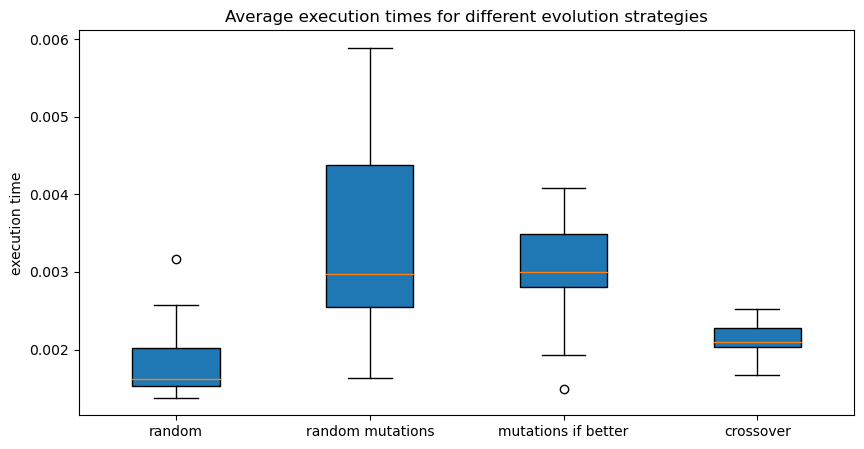

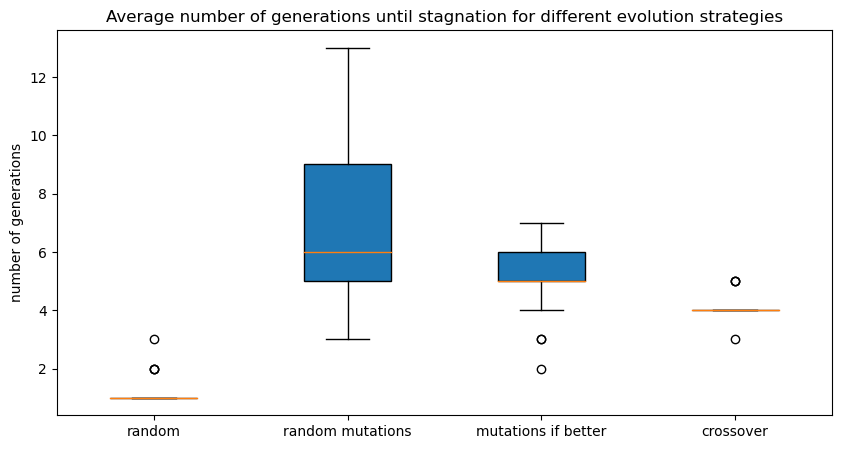

In [298]:
# test performances
random.seed(12345678910)
countRandom, timeRandom, popFitnessRandom = comparePerformances(correctBitPattern, population, typeOfLearning="random", withDifferentLengthBits=True)
countMutationRandom, timeMutationRandom, popFitnessMutationRandom = comparePerformances(correctBitPattern, population, typeOfLearning="mutationRandom", withDifferentLengthBits=True)
countMutationIfBetter, timeMutationIfBetter, popFitnessMutationIfBetter = comparePerformances(correctBitPattern, population, typeOfLearning="mutationIfBetter", withDifferentLengthBits=True)
countCrossOver, timeMutationCrossOver, popFitnessCrossOver = comparePerformances(correctBitPattern, population, typeOfLearning="crossover", withDifferentLengthBits=True)

# visualise
listAllFitnessesToCompare = [popFitnessRandom, popFitnessMutationRandom, popFitnessMutationIfBetter, popFitnessCrossOver]
listAllExecutionTimesToCompare = [timeRandom, timeMutationRandom, timeMutationIfBetter, timeMutationCrossOver]
listAllGenerationCountsToCompare = [countRandom, countMutationRandom, countMutationIfBetter, countCrossOver]
labelList = ["random", "random mutations", "mutations if better", "crossover"]
plotBoxplot(boxBlotContent = listAllFitnessesToCompare, title = 'Average fitness of best 30 pc for different evolution strategies,\n after stagnation (i.e. 1 generation no improvement)', yLabel = "fitness of best 30 pc", labels = labelList)
plotBoxplot(boxBlotContent = listAllExecutionTimesToCompare, title = 'Average execution times for different evolution strategies', yLabel = "execution time", labels = labelList)
plotBoxplot(boxBlotContent = listAllGenerationCountsToCompare, title = 'Average number of generations until stagnation for different evolution strategies', yLabel = "number of generations", labels = labelList)
